In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

from collections import Counter

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline

In [2]:
# models
from sklearn.linear_model import LogisticRegression, RidgeClassifier

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

Load the data:

In [3]:
df_train = pd.read_csv('onetwotrip_challenge_train.csv', index_col='orderid')
df_test = pd.read_csv('onetwotrip_challenge_test.csv', index_col='orderid')

## Analysis

In [4]:
df_train.shape, df_test.shape

((196056, 42), (455011, 36))

Look at the dataset:

In [5]:
pd.options.display.max_columns = 42
df_train.head(10)

,userid,field0,field1,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal21,goal22,goal23,goal24,goal25,goal1
orderid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,10d654494cbe97bbb25d51ead2600679aff9e097924add...,0,-0.626508,11,12,1,1,0,1,1,0,0,9,5,20,-0.661308,1,4,1,4,1,1,1,1,15,1,1,2,1,0,4,1,1,0,1,1,0,1,0,0,0,0
1,4aafc0391f72bbcf60537aece62923baf9ce644b64ac36...,144,-0.393794,5,7,2,0,0,2,1,0,0,21,125,3,-0.101043,1,57,1,5,1,6,2,121,15,1,41,3,1,0,2,1,1,0,1,0,0,0,0,0,0,0
2,bac8ffef46348f587c8d17137ab01fb24aef21547c647d...,134,-0.548937,2,3,2,0,0,1,1,0,1,7,4,3,-0.661308,1,4,1,2,3,6,2,17,14,1,1,11,7,0,1,1,1,0,1,1,0,0,0,0,0,0
3,0392247b4b87674aba2c32bf2292b105771a6a376871be...,0,-0.238651,10,11,1,1,3,2,1,0,0,19,12,3,-0.521242,2,22,1,3,3,4,1,46,12,2,18,1,1,0,4,1,1,0,1,1,0,0,0,0,0,0
4,d1aeefef311bbeb4bd84876c8d49421f276674527d5578...,0,-0.704079,8,11,1,1,0,1,1,0,1,16,4,3,-0.801375,1,100,1,6,1,1,1,17,22,1,1,1,1,0,3,1,1,0,0,1,0,0,0,0,0,0
5,bd2f85e3ed0cfa6ce641f632e4cfa35e170336ec5408cb...,0,-0.316223,9,9,1,1,0,1,1,0,0,10,5,62,-0.521242,2,0,1,6,5,6,1,1,17,1,1,1,1,1,3,1,1,0,0,0,0,0,0,0,0,0
6,6c6610f18ccd71f5ce664f9a840883d5d4b790d3adb88f...,0,0.071634,10,10,1,1,0,1,1,0,0,7,3,2,0.599289,1,6,1,4,2,3,1,22,5,1,1,1,1,0,4,1,1,1,1,1,0,1,0,0,0,0
7,daa23cdeee4840e522def77d76c05e4c9a1b64980d0aaa...,0,-0.238651,10,11,1,1,1,1,1,0,1,10,9,4,0.039024,1,22,1,5,2,6,1,44,21,1,1,7,5,0,4,1,1,1,1,0,0,1,1,0,0,0
8,c58f19409e035aafe7fd70b684ccd917402912c10b8a81...,0,-0.005937,8,8,1,1,0,1,1,0,1,14,9,3,-0.241109,2,1,1,1,1,2,1,21,9,2,1,1,1,0,3,1,1,1,0,1,0,1,0,0,0,0


All the features are anonymized. Look at the features' types:

In [6]:
df_train.dtypes

userid               object
field0                int64
field1              float64
field2                int64
field3                int64
field4                int64
field5                int64
field6                int64
field7                int64
field8                int64
field9                int64
field10               int64
field11               int64
field12               int64
field13               int64
field14             float64
field15               int64
field16               int64
field17               int64
field18               int64
field19               int64
field20               int64
field21               int64
field22               int64
field23               int64
field24               int64
field25               int64
field26               int64
field27               int64
field28               int64
field29               int64
indicator_goal21      int64
indicator_goal22      int64
indicator_goal23      int64
indicator_goal24      int64
indicator_goal25    

Count missing values: no missing values:

In [7]:
df_train.isna().sum().sum()

0

Count users - 113902 unique uses, 1.72 orders/user in average:

In [8]:
df_train.userid.nunique(), df_train.shape[0] / df_train.userid.nunique()

(113902, 1.7212691612087585)

### Feature generating

Create a new feature: flights per user:

In [9]:
gp = df_train.groupby(['userid']).size()
df_train['flights_per_user'] = df_train['userid'].map(gp)

# the same for the test set
gp = df_test.groupby(['userid']).size()
df_test['flights_per_user'] = df_test['userid'].map(gp)

Create a new feature: sum of the indicators per user:

In [10]:
# create a new feature
df_train['sum_indicators'] = df_train['indicator_goal21'] + df_train['indicator_goal22'] + df_train['indicator_goal23'] + \
                            df_train['indicator_goal24'] + df_train['indicator_goal25']
gp = df_train.groupby(['userid'])['sum_indicators'].mean()
df_train['indicators_per_user'] = df_train['userid'].map(gp)
df_train = df_train.drop(['sum_indicators'], axis=1)

# the same for the test set
df_test['sum_indicators'] = df_test['indicator_goal21'] + df_test['indicator_goal22'] + df_test['indicator_goal23'] + \
                            df_test['indicator_goal24'] + df_test['indicator_goal25']
gp = df_test.groupby(['userid'])['sum_indicators'].mean()
df_test['indicators_per_user'] = df_test['userid'].map(gp)
df_test = df_test.drop(['sum_indicators'], axis=1)

field_features = list(filter(lambda x: 'field' in x, df_train.columns))
flights_features = list(filter(lambda x: 'flights' in x, df_train.columns))
indicator_features = list(filter(lambda x: 'indicator' in x, df_train.columns))

features = field_features + indicator_features
features_train = features + flights_features

Notice that the dataset is imbalanced: 2% of 1, 98% of 0, it should be handled further:

In [11]:
df_train.goal1.mean()

0.022141633002815523

Split the data frame into X (inputs) and y (outputs):

In [12]:
X_train, y_train = df_train[features_train], df_train.goal1
X_test = df_test[features_train]

Let's look at the min and max values of the features to guess the features' meanings:

In [13]:
X_train.describe()

,field0,field1,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,indicators_per_user,flights_per_user
count,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000
mean,28.413163,0.000912,7.980363,7.867864,3.528966,0.556214,1.577911,1.265292,0.879366,0.023937,0.448117,14.633431,12.010492,27.046028,0.001822,1.517153,15.723854,3.001301,3.811941,2.076172,3.993762,1.226471,38.751938,13.028186,1.404645,4.923456,3.875780,1.746557,0.088572,2.980837,0.994966,0.979649,0.348676,0.645754,0.647687,3.616732,6.057932
std,69.603944,1.009651,2.757008,3.013659,12.692057,0.496831,5.614900,0.441489,0.325702,0.164366,0.497302,5.519693,19.579464,55.490962,1.007327,0.952774,25.689926,8.510708,1.931365,0.980940,1.975246,0.418548,71.517212,6.132370,0.784647,11.652149,4.230396,1.376456,0.369773,0.919229,0.070774,0.141199,0.476552,0.478285,0.477692,0.760969,21.779353
min,0.000000,-0.859222,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-0.941441,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,-0.471365,6.000000,6.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,11.000000,4.000000,3.000000,-0.521242,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3.000000,1.000000
50%,0.000000,-0.238651,8.000000,8.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,15.000000,5.000000,4.000000,-0.241109,1.000000,6.000000,1.000000,4.000000,2.000000,4.000000,1.000000,17.000000,13.000000,1.000000,1.000000,2.000000,1.000000,0.000000,3.000000,1.000000,1.000000,0.000000,1.000000,1.000000,3.773585,2.000000
75%,13.000000,0.149205,10.000000,10.000000,2.000000,1.000000,0.000000,2.000000,1.000000,0.000000,1.000000,19.000000,11.000000,26.000000,0.179090,2.000000,18.000000,1.000000,5.000000,3.000000,6.000000,1.000000,42.000000,18.000000,2.000000,1.000000,5.000000,3.000000,0.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000
max,500.000000,82.142134,12.000000,12.000000,363.000000,1.000000,323.000000,2.000000,1.000000,4.000000,1.000000,23.000000,273.000000,746.000000,55.225183,18.000000,340.000000,156.000000,7.000000,8.000000,7.000000,2.000000,867.000000,23.000000,18.000000,170.000000,28.000000,7.000000,8.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,363.000000


Some features are like time points: day of the week (1..7), hour (0..23), month (1..12),
in each group one if them may be the buy time, and the rest one - the flight time

In [14]:
month_features = ['field2', 'field3']
hour_features = ['field11', 'field23']
weekday_features = ['field18', 'field20', 'field27']
binary_features = ['field5', 'field8', 'field10']
float_features = ['field1', 'field14']
features_15_24 = ['field15', 'field24']

### Plot the distributions

Let's plot the dustribution of the field1 (float) feature:

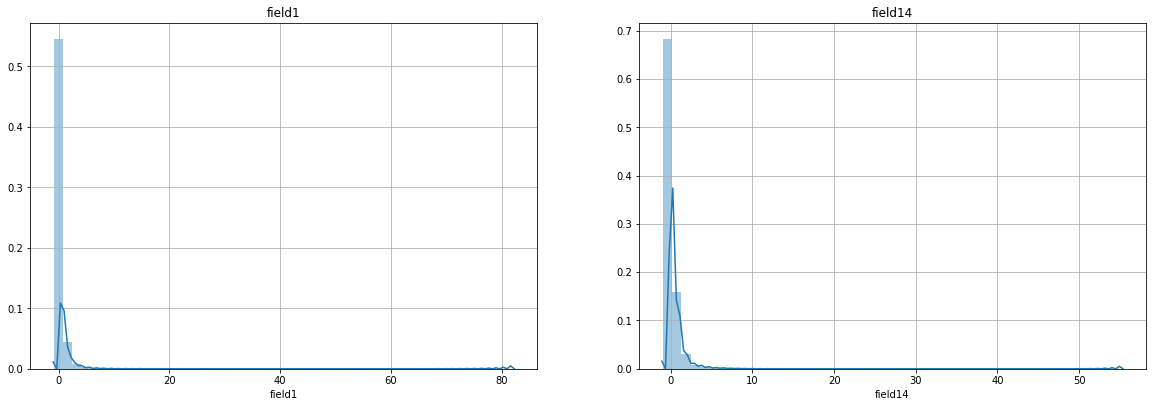

In [15]:
plt.figure(figsize=(20, 14))
plt.subplot(221)
sns.distplot(df_train['field1'])
plt.title('field1')
plt.grid(True)
plt.subplot(222)
sns.distplot(df_train['field14'])
plt.title('field14')
plt.grid(True);

It seems that the field1 and field14 are some standartized features:

In [16]:
print (np.mean(df_train['field1']), np.std(df_train['field1']))
print (np.mean(df_train['field14']), np.std(df_train['field14']))

0.0009120241273193246 1.0096482387577506
0.0018215054539153998 1.0073247428907823


Plot the months:

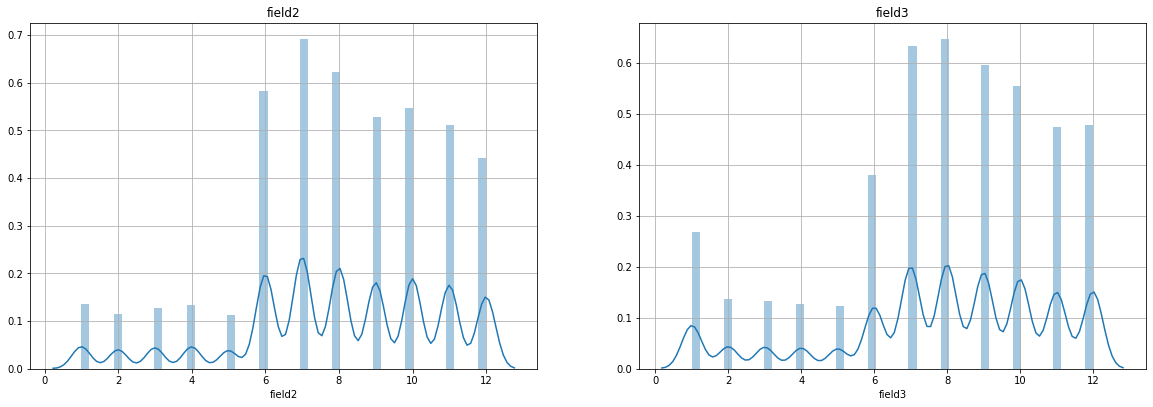

In [17]:
plt.figure(figsize=(20, 14))
plt.subplot(221)
sns.distplot(df_train[month_features[0]])
plt.title('field2')
plt.grid(True)
plt.subplot(222)
sns.distplot(df_train[month_features[1]])
plt.title('field3')
plt.grid(True);

The histograms for months are very similar. It seems that people bought more tickets/did more flights in the 2nd half of year.

Plot the hours:

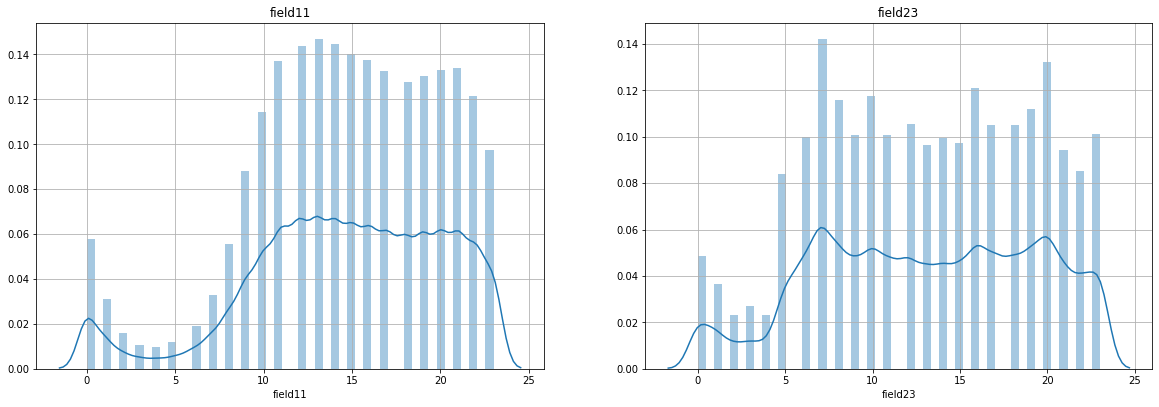

In [18]:
plt.figure(figsize=(20, 14))
plt.subplot(221)
sns.distplot(df_train[hour_features[0]])
plt.title('field11')
plt.grid(True)
plt.subplot(222)
sns.distplot(df_train[hour_features[1]])
plt.title('field23')
plt.grid(True);

The histograms for hours are very similar. People bought more tickets/did more flights in the working day.

Plot the weekdays:

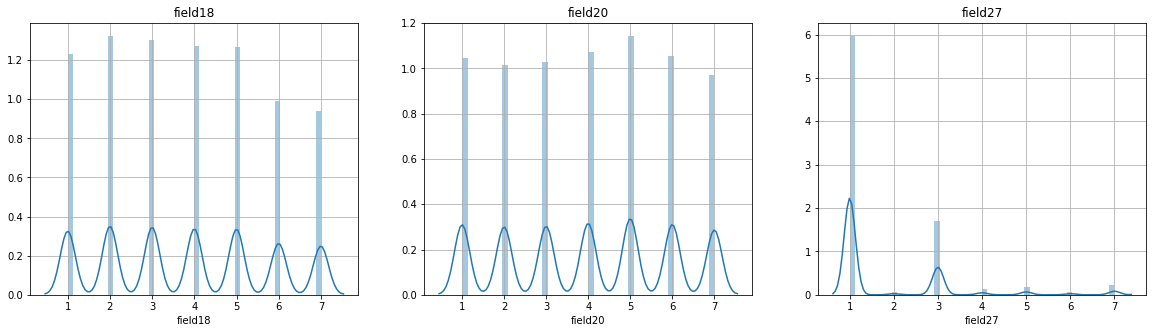

In [19]:
plt.figure(figsize=(20, 5))
plt.subplot(131)
sns.distplot(df_train[weekday_features[0]])
plt.title('field18')
plt.grid(True)
plt.subplot(132)
sns.distplot(df_train[weekday_features[1]])
plt.title('field20')
plt.grid(True);
plt.subplot(133)
sns.distplot(df_train[weekday_features[2]])
plt.title('field27')
plt.grid(True);

The first two histograms for are similar, they really can be the weekdays. The third one is not a weekday.

### Corellation analysis

Let's look at correlations between variables to check multicollinearity:

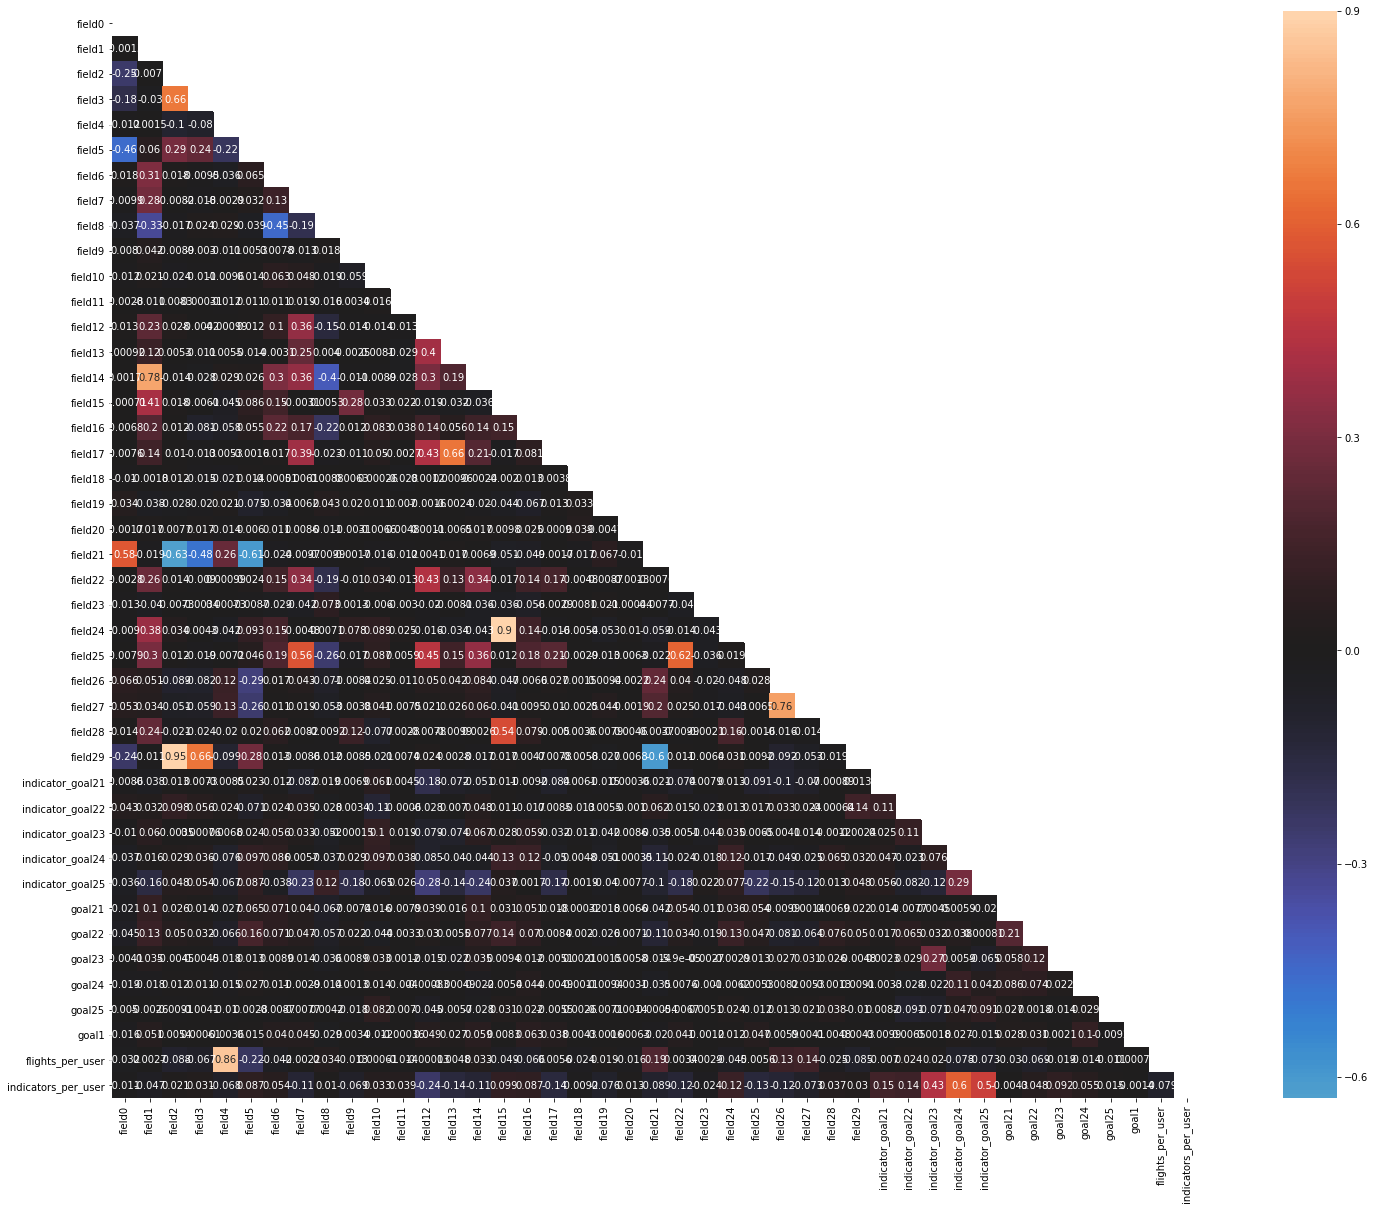

In [20]:
plt.subplots(figsize = (30, 20))

mask = np.zeros_like(df_train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_train.corr(), mask=mask, vmax=0.9, square=True, annot=True, center=0);

We see that some fields have a very high correlation:
- field2 and field29: corr=0.95
- field15 and field24: corr=0.9 (range = 1..18)
- field4 and flights_per_user: corr=0.86
- field1 and field14: corr=0.78 (floats)
- field26 and field27: corr=0.76
- field3 and field29: corr=0.66
- field13 and field17: corr=0.66
- field2 and field3: corr=0.66 (months)

Let's plot some correlations:

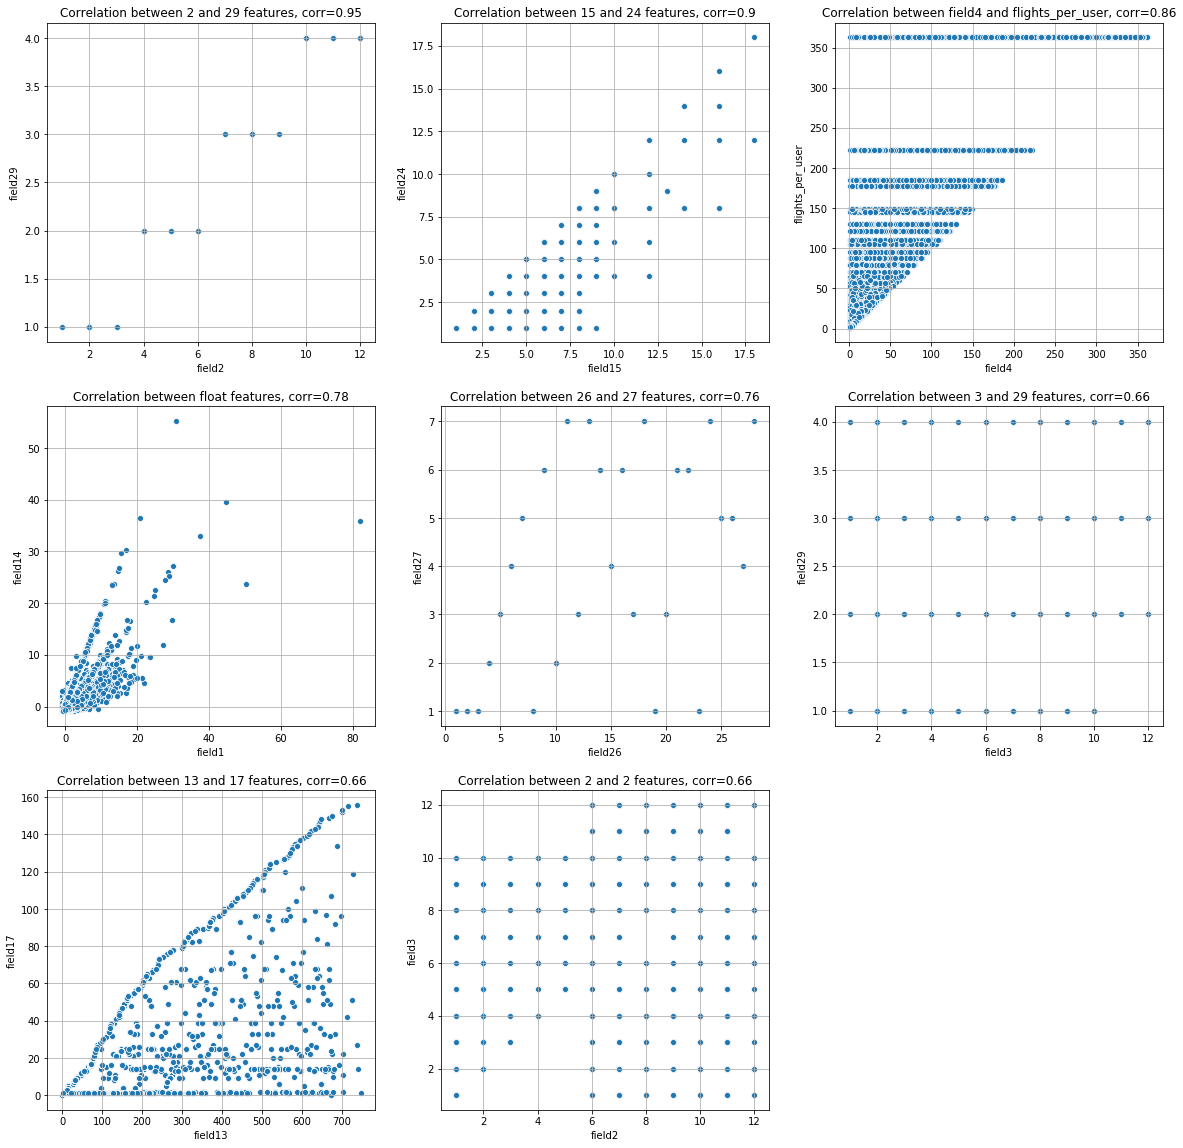

In [21]:
plt.figure(figsize=(20, 20))
plt.subplot(331)
sns.scatterplot(X_train['field2'], X_train['field29'])
plt.title('Correlation between 2 and 29 features, corr=0.95')
plt.grid(True)
plt.subplot(332)
sns.scatterplot(X_train[features_15_24[0]], X_train[features_15_24[1]])
plt.title('Correlation between 15 and 24 features, corr=0.9')
plt.grid(True)
plt.subplot(333)
sns.scatterplot(X_train['field4'], X_train['flights_per_user'])
plt.title('Correlation between field4 and flights_per_user, corr=0.86')
plt.grid(True)
plt.subplot(334)
sns.scatterplot(X_train['field1'], X_train['field14'])
plt.title('Correlation between float features, corr=0.78')
plt.grid(True)
plt.subplot(335)
sns.scatterplot(X_train['field26'], X_train['field27'])
plt.title('Correlation between 26 and 27 features, corr=0.76')
plt.grid(True)
plt.subplot(336)
sns.scatterplot(X_train['field3'], X_train['field29'])
plt.title('Correlation between 3 and 29 features, corr=0.66')
plt.grid(True)
plt.subplot(337)
sns.scatterplot(X_train['field13'], X_train['field17'])
plt.title('Correlation between 13 and 17 features, corr=0.66')
plt.grid(True)
plt.subplot(338)
sns.scatterplot(X_train['field2'], X_train['field3'])
plt.title('Correlation between 2 and 2 features, corr=0.66')
plt.grid(True);

From this scatter plots, we can conclude that:
- field15 >= field24
- flights_per_user >= field4
- field13 >= field17

Correlation between the target and the features:

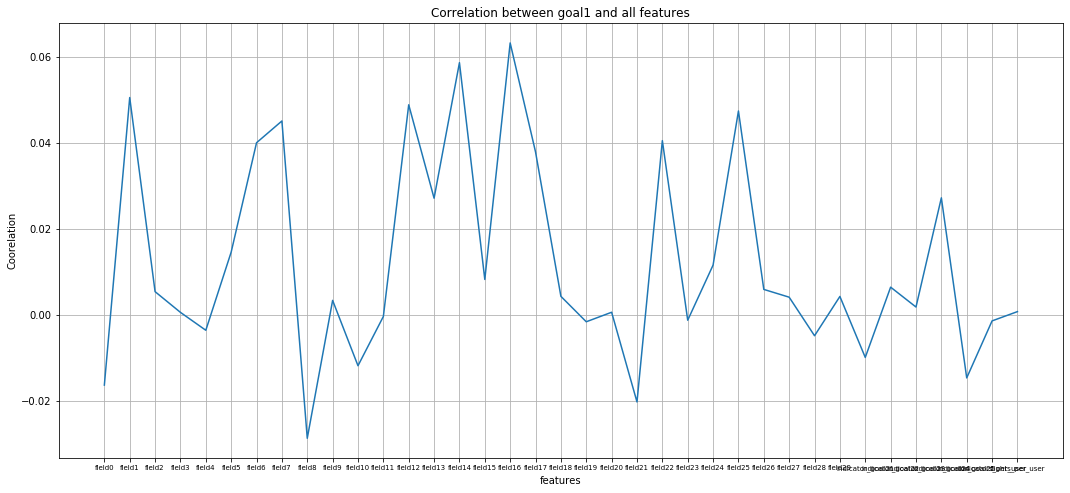

In [22]:
X = pd.concat([X_train, y_train], axis=1)

plt.figure(figsize=(18, 8))
plt.plot(X.corr(method='pearson')['goal1'].drop('goal1', axis=0))
plt.xticks(size=7)
plt.ylabel('Coorelation')
plt.xlabel('features')
plt.title('Correlation between goal1 and all features')
plt.grid(True);

We see that goal1 has pretty low correlation with the features.

It seems that the field1 and field14 are some standartized features:

In [23]:
print (np.mean(df_train['field1']), np.std(df_train['field1']))
print (np.mean(df_train['field14']), np.std(df_train['field14']))

0.0009120241273193246 1.0096482387577506
0.0018215054539153998 1.0073247428907823


## Model selection

We should choose a model with considering that we are dealing with imbalanced classes problem.
Decision trees frequently perform well on imbalanced data. They work by learning a hierarchy of if/else questions and this can force both classes to be addressed.

So, we tried LogisticRegression, RidgeClassifier, but tree methods: LightGB, XGBoost, RandomForest gave better accuracy.

To handle imbalanced classes, we used:

a) Roc-auc metric: "accuracy" is not the best metric to use when evaluating imbalanced datasets as it can be very misleading because in the case of constant prediction of 0 the accuracy will be 98%, that is wrong.

b) balancing of the class weights (class_weight='balanced' parameter in the classifier definition)

c) stratified folds during cross-validation (cv=StratifiedKFold(n_splits=3))
"This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class."
 
 d) also, there are some sampling methods:
 - Oversampling - duplicating or synthesizing new samples from the minority class
 - Undersampling - deleting or selecting only a sample of examples from the majority class
 
 The first one leads to potential overfitting, and increases learning and processing time, the second one leads to loss of useful data. So, they are not preferred to b) and c) and, if done, should be carefully implemented. So, we did not use them.

In [29]:
counter = Counter(y_train)
weight = counter[0] / counter[1]

catb = CatBoostClassifier(logging_level='Silent', random_state=0)

lr = LogisticRegression(class_weight='balanced')
params_lr = {'penalty': ['l1'], 'C': np.logspace(-2, 4, 7)}

ridge = RidgeClassifier(class_weight='balanced')
params_ridge = {'alpha': [0.1, 10, 15, 20, 50, 100]}

lgb = LGBMClassifier(class_weight='balanced')
params_lgb = {'random_state': [42], 'max_depth': [5, 9, 10, 15, 20], 'n_estimators': [10, 20, 50, 100]} # 0.6811

xgb = XGBClassifier(scale_pos_weight=weight)
params_xgb = {'random_state': [42], 'max_depth': [3, 4, 5, 6], 'n_estimators': [5, 10, 20]}

rf = RandomForestClassifier(class_weight='balanced')
params_rf = {'random_state': [42], 'max_depth': [5, 6, 7, 8], 'n_estimators': [20, 30, 50]}

In [30]:
clf = lgb
params = params_lgb

cv = GridSearchCV(clf, params, scoring='roc_auc', cv=StratifiedKFold(n_splits=3), n_jobs=4)
cv.fit(X_train, y_train)
cv.best_score_, cv.best_estimator_

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


(0.6810703575288423,
 LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
                colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
                max_depth=10, min_child_samples=20, min_child_weight=0.001,
                min_split_gain=0.0, n_estimators=20, n_jobs=-1, num_leaves=31,
                objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
                silent=True, subsample=1.0, subsample_for_bin=200000,
                subsample_freq=0))

The model that performed the best, were LightGBM.

## Predict with the best classifier

In [31]:
clf = cv.best_estimator_
clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=10, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=20, n_jobs=-1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [32]:
proba = clf.predict_proba(X_test)
pd.DataFrame(proba[:, 1], columns=['proba'], index=df_test.index).to_csv('sub1.csv')

### The most important features

In [35]:
best_features = np.argsort(abs(clf.feature_importances_))[::-1][:5]
best_features

array([12, 16,  0, 14, 35], dtype=int64)

So, the most important features are:
- field12
- field16
- field0
- field14
- indicators_per_user